# Ridge regression
**Important**: Change the kernel to *PROJECT_NAME local*. You can do this from the *Kernel* menu under *Change kernel*.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
import pickle
import os
import scipy.stats as st
from azure.storage.blob import BlockBlobService

In [2]:
from azureml.logging import get_azureml_logger
run_logger = get_azureml_logger()
run_logger.log('amlrealworld.timeseries.ridge','true')

In [3]:
model_name = "ridge"
aml_dir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']
ACCOUNT_NAME = "petcgexperimentstorage"
ACCOUNT_KEY = "C+ffy45PBcicHAxWiRbW9MnFR651A8xbiVe2wkyZgolznhFf70caTZmpWIJb2spV5YFl/LQB0ARUfU+AQx6w9g=="
CONTAINER_NAME = "energy-demand-demo"
block_blob_service = BlockBlobService(account_name=ACCOUNT_NAME, account_key=ACCOUNT_KEY)
train = None
list_of_blobs = block_blob_service.list_blobs(CONTAINER_NAME)
for each_blob in list_of_blobs:
    if ("part-00" in each_blob.name):
        block_blob_service.get_blob_to_path(CONTAINER_NAME, blob_name=each_blob.name, file_path='./nyc_demand.csv')
        train = pd.read_csv('./nyc_demand.csv')
        break

Create model pipeline:
- **one-hot encode categorical variables**
- **randomized parameter search** with cross validation to find optimal values for the alpha parameter

Fitting this pipeline should take less than a minute.

In [4]:
X = train.drop(['demand', 'timeStamp'], axis=1)

In [5]:
cat_cols = ['hour', 'month', 'dayofweek']
cat_cols_idx = [X.columns.get_loc(c) for c in X.columns if c in cat_cols]
onehot = OneHotEncoder(categorical_features=cat_cols_idx, sparse=False)
regr = Ridge(fit_intercept=False)
tscv = TimeSeriesSplit(n_splits=3)

In [8]:
param_dist = {'alpha': st.uniform(1e-4, 10.0)}
regr_cv = RandomizedSearchCV(estimator=regr,
                            param_distributions=param_dist,
                            n_iter=100,
                            scoring='neg_mean_squared_error',
                            iid=False,
                            cv=tscv,
                            verbose=2,
                            n_jobs=-1)
regr_pipe = Pipeline([('onehot', onehot), ('regr_cv', regr_cv)])
regr_pipe.fit(X, y=train['demand'])

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   22.0s finished


Pipeline(steps=[('onehot', OneHotEncoder(categorical_features=[2, 3, 4], dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)), ('regr_cv', RandomizedSearchCV(cv=TimeSeriesSplit(n_splits=3), error_score='raise',
          estimator=Ridge(alpha=1.0, copy_X=True, fit_int...it=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=2))])

In [9]:
model_dir = "C:/Users/nelgoh/Desktop/Resources/Petronas/energy_demand_forecast/EnergyDemandForecast/outputs/models/"
with open(os.path.join(model_dir, model_name + '.pkl'), 'wb') as f:
    pickle.dump(regr_pipe, f)

Cross validation results

In [8]:
cv_results = pd.DataFrame(regr_pipe.named_steps['regr_cv'].cv_results_)
cv_results.sort_values(by='rank_test_score').head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
53,0.161684,0.008320,-3878.856377,-4220.634324,6.25828,{'alpha': 6.2582768398},1,-4167.555577,-4383.378473,-3679.067260,-4237.609211,-3789.946293,-4040.915289,0.033796,0.002497,209.099595,140.324310
88,0.173995,0.010000,-3878.862265,-4221.069535,6.57229,{'alpha': 6.57229209519},2,-4168.054855,-4384.281248,-3678.881404,-4237.880354,-3789.650536,-4041.047003,0.029640,0.004547,209.430523,140.628090
38,0.174331,0.010678,-3878.862703,-4220.329083,6.03259,{'alpha': 6.03258550443},3,-4167.216235,-4382.743722,-3679.207911,-4237.419917,-3790.163964,-4040.823612,0.007407,0.002614,208.867790,140.110463
5,0.164329,0.013667,-3878.863535,-4220.306645,6.0158,{'alpha': 6.0158039063},4,-4167.191673,-4382.697007,-3679.218610,-4237.406031,-3790.180323,-4040.816896,0.048651,0.001885,208.850763,140.094716
74,0.184668,0.007669,-3878.864215,-4220.289251,6.00278,{'alpha': 6.00277677208},5,-4167.172670,-4382.660789,-3679.226938,-4237.395271,-3790.193038,-4040.811692,0.040929,0.001695,208.837565,140.082507


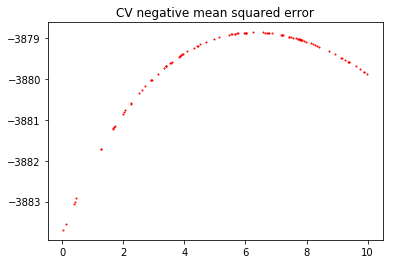

In [9]:
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], 'ro', markersize=1)
plt.title('CV negative mean squared error')
plt.show()